In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.python.util import compat
from tensorflow.core.protobuf import saved_model_pb2
from google.protobuf import text_format
import pprint
import os

In [ ]:
!ls /content

kaggle.json  labelmap.pbtxt  models  sample_data


In [ ]:
!mkdir -p /root/.kaggle/
!mv /content/kaggle.json /root/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle d download johnsyin97/hardhat-and-safety-vest-image-for-object-detection

 94% 297M/315M [00:06<00:00, 50.6MB/s]
100% 315M/315M [00:06<00:00, 47.3MB/s]


In [ ]:
!unzip hardhat-and-safety-vest-image-for-object-detection.zip

In [ ]:
!kaggle d download bouweceunen/pretrained-trt-engines-cocotacohardhatposenet

 97% 634M/657M [00:12<00:00, 41.8MB/s]
100% 657M/657M [00:13<00:00, 52.9MB/s]


In [ ]:
!unzip pretrained-trt-engines-cocotacohardhatposenet.zip

In [ ]:
! rm -rf ./models && git clone https://github.com/tensorflow/models.git \
    && cd models/research \
    && protoc object_detection/protos/*.proto --python_out=. \
    && cp object_detection/packages/tf2/setup.py . && \
    python3 -m pip install --use-feature=2020-resolver .

In [ ]:
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import dataset_util, label_map_util
from object_detection.protos import string_int_label_map_pb2

In [ ]:
# reconstruct frozen graph
def reconstruct(pb_path):
    if not os.path.isfile(pb_path):
        print("Error: %s not found" % pb_path)

    print("Reconstructing Tensorflow model")
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.compat.v1.GraphDef()
        with tf.io.gfile.GFile(pb_path, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    print("Success!")
    return detection_graph

In [ ]:
# visualize detection
def image2np(image):
    (w, h) = image.size
    return np.array(image.getdata()).reshape((h, w, 3)).astype(np.uint8)

def image2tensor(image):
    npim = image2np(image)
    return np.expand_dims(npim, axis=0)

%matplotlib inline
def detect(detection_graph, test_image_path):
    with detection_graph.as_default():
        gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.01)
        with tf.compat.v1.Session(graph=detection_graph,config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)) as sess:
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            image = Image.open(test_image_path)
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image2tensor(image)}
            )

            npim = image2np(image)
            vis_util.visualize_boxes_and_labels_on_image_array(
                npim,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=5)
            plt.figure(figsize=(12, 8))
            plt.imshow(npim)
            plt.show()

<h2> Create Label Map

In [ ]:
categories = ["hardhat", "none"]
NCLASSES = 2

In [ ]:
print('Building label map from examples')

labelmap = string_int_label_map_pb2.StringIntLabelMap()
for idx,category in enumerate(categories):
    item = labelmap.item.add()
    # label map id 0 is reserved for the background label
    item.id = idx+1
    item.name = category

with open('./labelmap.pbtxt', 'w') as f:
    f.write(text_format.MessageToString(labelmap))

print('Label map witten to labelmap.pbtxt')

with open('./labelmap.pbtxt') as f:
    pprint.pprint(f.readlines())

Building label map from examples
Label map witten to labelmap.pbtxt
['item {\n',
 '  name: "hardhat"\n',
 '  id: 1\n',
 '}\n',
 'item {\n',
 '  name: "none"\n',
 '  id: 2\n',
 '}\n']


In [ ]:
label_map = label_map_util.load_labelmap('labelmap.pbtxt')
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NCLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

<h2> Reconstruct Frozen Graph

In [ ]:
detection_graph = reconstruct("/content/base-models/ssd_mobilenet_v2_hardhat_2018_03_29.pb")

Reconstructing Tensorflow model
Success!


<h2> Validate Images

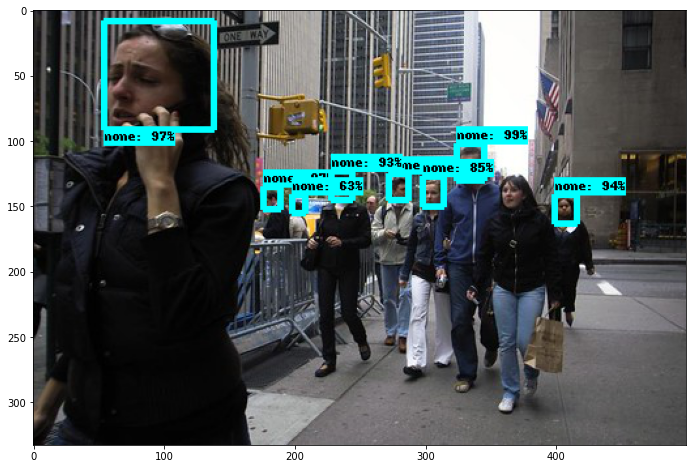

In [ ]:
detect(detection_graph, '/content/train/neg_100.jpg')

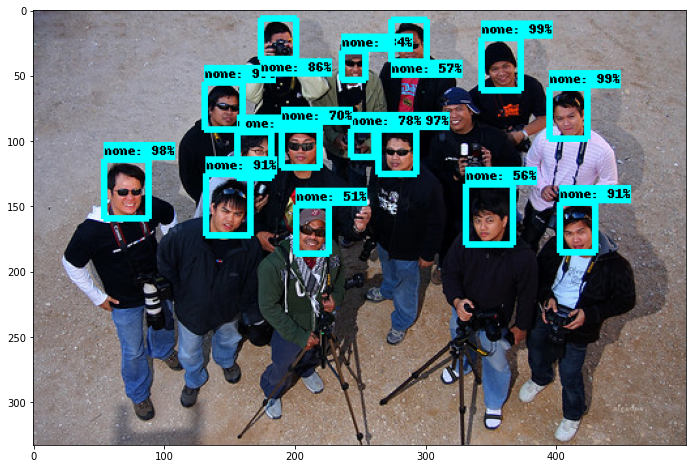

In [ ]:
detect(detection_graph, '/content/train/neg_1099.jpg')

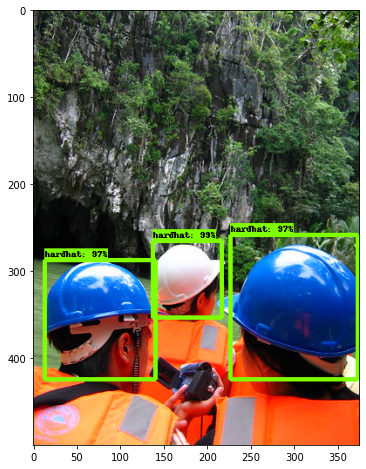

In [ ]:
detect(detection_graph, '/content/train/pos_942.jpg')

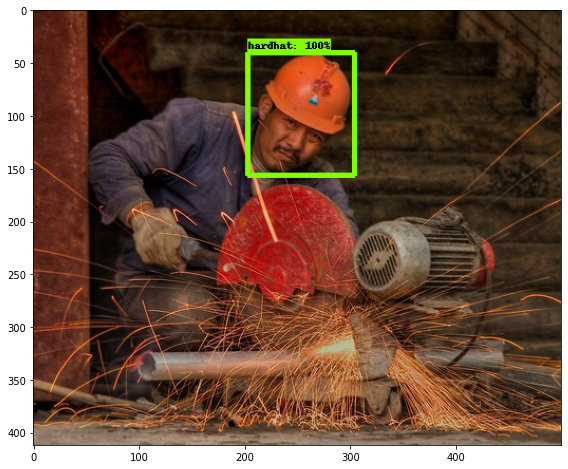

In [ ]:
detect(detection_graph, '/content/train/pos_970.jpg')

In [ ]:
!kaggle d download savanagrawal/detect-person-on-motorbike-or-scooter

 98% 345M/352M [00:06<00:00, 78.1MB/s]
100% 352M/352M [00:06<00:00, 55.9MB/s]


In [ ]:
!mkdir ./motorbike
!unzip detect-person-on-motorbike-or-scooter.zip -d ./motorbike

In [ ]:
import os
from PIL import Image
import fnmatch


path = r'./motorbike/dataset/obj/'
for dimage in fnmatch.filter(os.listdir(path),"*.jpg"):
  # set the base width of the result
  basewidth = 300
  img = Image.open(path+dimage)
  # determining the height ratio
  wpercent = (basewidth/float(img.size[0]))
  hsize = int((float(img.size[1])*float(wpercent)))
  # resize image and save
  img = img.resize((basewidth,hsize), Image.ANTIALIAS)
  img.save(path+dimage) 
  pass
print(image)

OSError: ignored

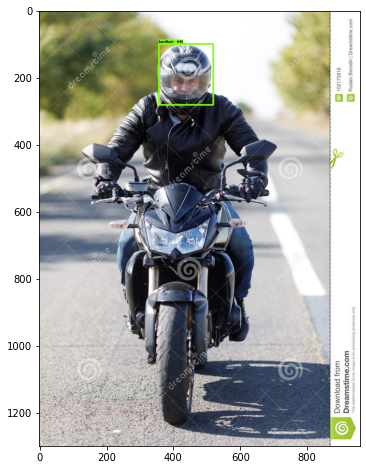

In [ ]:
import random
detect(detection_graph, f'./motorbike/dataset/obj/{random.randint(1,100)}.jpg')